# Introduction

Disclaimer: This project is currently a proof of concept only. 

### OVERVIEW: 
This notebook is where I'll be developing an algorithm for a twitterbot, HurriHelp to use. HurriHelp aims to connect folks tweeting using the #HurricaneIan hashtag with the National Disaster Distress Helpline (1-800-985-5990) and a link directing them to FEMA's page about Hurricane Ian (https://www.fema.gov/disaster/4673) in real time if they are in distress. The algorithm was trained on data with sentiment analysis to judge whether or not to engage. 

### Problem: 
FEMA's twitter cannot respond to every tweet using the #HurricaneIan hashtag, and the people making those tweets need proactive information and resources. 

### The stakeholder:
This algorithm is meant to serve folks who have been negatively impacted by Hurricane Ian and who are tweeting about it.

### Example Use Case: 
<'twitter_user'> is in distress since Hurricane Ian destroyed their home. They tweet "HurricaneIan wrecked my home of 20 years. I don't know what to do. I'm devastated." Within minutes, HurriHelp responds to their tweet saying "Hi! I'm HurriHelp, a hurricane helper bot. Here's some resources. National Disaster Distress Helpline (1-800-985-5990), for more info: https://www.fema.gov/disaster/4673" 

### Data Understanding: 
I'll be using data that I scraped from Twitter. All these tweets contained the #HurricaneIan hashtag. The data I scraped from twitter has more features than I'm able to analyze or use currently for this project, and am saving a majority of analysis about them for future work. From the scrape, I've already filtered out Retweets and duplicates, so only the original tweets remain. 

Of the features the following came directly from my twitter scrape: text,	screen_name,	user_description,	favourite_count	retweet_count,	created_at,	replying_to	media,	hashtags,	urls,	user_mentions,	is_quote,	is_retweet. Of these features I'll be using only the "text" for analysis and modeling. 

The features containing sentiment analysis: text_blob,	bert,	vader_compound,	bert_label I've engineered in a previous notebook. The first step will be making a cohesive sentiment label from text_blob, bert and vader. 

The data contains 7653 rows, each representing an instance of an original tweet containing the #HurricaneIan hashtag. 

#### Limitations:
This data is limited in that it's a small sample, compared to what's possible. I also could use a staggered sampling technique in future work. In modeling I wasn't able to get a better than 80% F1 score. It's worth investigating whether a larger amount of training data, or training data taken over a larger sample time would result in better metrics. 

#### Bias:
Because I used a neural network to make my labels I will *not* be using a neural network in my modeling to avoid bias. 


## Imports

In [1]:
# importing all the libraries I'll need 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import spacy 
import nltk
from nltk.collocations import *
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from  nltk import FreqDist

import string
import contractions
from cleantext import clean

from scipy.sparse import csr_matrix

from xgboost import XGBClassifier 
from catboost import CatBoostClassifier

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [2]:
sns.set_style("white")

## FUNCTIONS

In [3]:
# Making an empty list to store the classification reports my models with produce

reports = []
top_20_words = []

In [4]:
# Making a funciton to give me a ROC_AUC plot and classification report for 
# each model

def evaluate(model, X_val, y_val, y_preds):
    """
    DOCSTRING: 
    evaluate expects a model, a list of y_trues and associated list of 
    y_predicted. it outputs a confusion matrix of PRECICSION values (noramalize is
    set to 'preds') and the associated precision, recall, f1 and support scores
    """

    lables = ['Negative Sentiment', 'Positive Sentiment']    
    
    ROC_AUC = metrics.plot_roc_curve(estimator = model, X = X_val, y = y_val,
                                     pos_label = 0)
    
    report = classification_report(y_val, y_preds, target_names = lables,
                                       output_dict = False)

    dict_report = classification_report(y_val, y_preds, target_names = lables,
                                       output_dict = True)
    reports.append(dict_report)
    print(ROC_AUC);
    print('************************************************************')
    print("FULL REPORT")
    print('************************************************************')
    print(report)

In [5]:
def most_common(doc_string, sentiment_name):
    
    """
    DOCSTRING: intakes a string and a sentiment name and returns a plot of the 
    most common words in that string, with the labels showing the sentiment name
    """
    sns.set_style('white')
    doc = nlp(doc_string)

    tokens = [token.text for token in doc]

    freqdist = FreqDist(tokens)

    most_common = freqdist.most_common(20)
    most_common_df = pd.DataFrame(most_common)
    most_common_df.head()
    
    
    plt.figure(figsize = (8, 8))
    plt.xticks(rotation=45)

    top_20 = sns.barplot(x = 0, y = 1, data = most_common_df, color= 'blue')
    top_20.set_xlabel(f"Most Common Words in {sentiment_name}")
    top_20.set_ylabel("Frequencies")
    top_20.set_title("Top 20 Words in Hurricane Ian Tweets")
    return most_common, top_20;

In [6]:
def bigrams(sentiment_tokens, sentiment_name, name):
    
    """
    DOCSTRING: intakes a list of tokens and a sentiment name and returns 
    a bigram plot of the most common intersection of words in those tokens,
    with the sentiment name labeled in the plot
    """

    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(sentiment_tokens)
    scored = finder.score_ngrams(bigram_measures.raw_freq)
    top_20_bigram = pd.DataFrame(scored[:20])
    top_20_bigram.head()
    
    bigrams = [str(x).strip('()').title() for x in top_20_bigram[0]]
    top_20_bigram[0] = bigrams
    top_20_bigram[1] = [100 * (round(float(x), ndigits = 4)) for x in top_20_bigram[1]]
    
    plt.figure(figsize = (8, 8))

    top_20 = sns.barplot(x = 0, y = 1, data = top_20_bigram, color = 'green')
    top_20.set_xlabel("Bigrams")
    top_20.set_ylabel("Frequencies in Percentages")
    top_20.set_title(f"Top 20 Two-Word Combinations in {sentiment_name}")
    plt.xticks(rotation = 65)
    plt.tight_layout()
    plt.savefig(f"{name}");

In [7]:
def make_word_cloud(text, name):
    
    """
    DOC STRING: intakes takes and makes a word cloud
    """

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bicubic')
    plt.axis("off")
    plt.show()
    plt.savefig(f"{name}")
    
    wordcloud.to_file(f'{name}.png')

In [8]:
def get_cat_preds(clf, X):
    predict_probas = clf.predict_proba(X)
    y_preds = []
    for x in predict_probas:
        if x[0] > x[1]:
            y_preds.append(0)
        if x[0] < x[1]:
            y_preds.append(1)
    return y_preds

## Voting

In [9]:
# Loading the data 

df = pd.read_csv('data_sets/ready_for_analysis.csv')
df = df.drop(columns='Unnamed: 0')
df.head()

,text,screen_name,user_description,favourite_count,retweet_count,created_at,replying_to,media,hashtags,urls,user_mentions,is_quote,is_retweet,text_blob,bert,vader_compound,bert_label
0,“#Florida's death toll from #HurricaneIan tops...,AmPowerBlog,Sports Twitter is the best Twitter. 🏈🏇🎾🛹⚾🏌️😎🚴🏐...,0,0,2022-10-03 20:19:43+00:00,NaN,False,"[{'text': 'Florida', 'indices': [1, 9]}, {'tex...","[{'url': 'https://t.co/RqcyAHAxtk', 'expanded_...",[],False,False,0.000000,"[{'label': 'Positive', 'score': 0.352827787399...",-0.1531,Positive
1,Republicans. can’t. be. counted. on. to. do. ...,nivnos33,#RESISTER #Woke #Democrat #NeverGOP #VotingRig...,0,0,2022-10-03 20:19:22+00:00,NaN,False,"[{'text': 'VoteOutEveryRepublican', 'indices':...","[{'url': 'https://t.co/Me3qmrzTsX', 'expanded_...",[],True,False,0.285714,"[{'label': 'Neutral', 'score': 0.3550549745559...",0.0000,Neutral
2,Leadership you can Trust. 🦟 Make sure to like ...,TrishTheCommish,"#Commissioner, #Mom, #PublicServant, #Mosquito...",2,0,2022-10-03 20:19:09+00:00,NaN,True,"[{'text': 'leadbyexample', 'indices': [180, 19...",[],[],False,False,0.625000,"[{'label': 'Neutral', 'score': 0.4122076034545...",0.9134,Neutral
3,"Hello Everyone,\n1/3) Many Floridians face flo...",Find_and_Bind1,"Amateur journalist, photographer, #bondage ent...",0,0,2022-10-03 20:18:56+00:00,NaN,False,"[{'text': 'HurricaneIan', 'indices': [112, 125...","[{'url': 'https://t.co/lgO1y1sFsK', 'expanded_...",[],False,False,0.500000,"[{'label': 'Positive', 'score': 0.351958453655...",-0.3182,Positive
4,"Lord, please be a refuge for those in need. Gi...",shellsfaith,My name is Shelly and this is where I will be ...,1,0,2022-10-03 20:18:45+00:00,NaN,False,"[{'text': 'HurricaneIan', 'indices': [195, 208...","[{'url': 'https://t.co/M4c6nH2x1U', 'expanded_...",[],True,False,-0.200000,"[{'label': 'Neutral', 'score': 0.3944049477577...",0.7579,Neutral


In [10]:
# Dropping the 'bert_label' as I'll be bert's numeric score instead

df = df.drop(columns = ['bert_label'])
df.head()

,text,screen_name,user_description,favourite_count,retweet_count,created_at,replying_to,media,hashtags,urls,user_mentions,is_quote,is_retweet,text_blob,bert,vader_compound
0,“#Florida's death toll from #HurricaneIan tops...,AmPowerBlog,Sports Twitter is the best Twitter. 🏈🏇🎾🛹⚾🏌️😎🚴🏐...,0,0,2022-10-03 20:19:43+00:00,NaN,False,"[{'text': 'Florida', 'indices': [1, 9]}, {'tex...","[{'url': 'https://t.co/RqcyAHAxtk', 'expanded_...",[],False,False,0.000000,"[{'label': 'Positive', 'score': 0.352827787399...",-0.1531
1,Republicans. can’t. be. counted. on. to. do. ...,nivnos33,#RESISTER #Woke #Democrat #NeverGOP #VotingRig...,0,0,2022-10-03 20:19:22+00:00,NaN,False,"[{'text': 'VoteOutEveryRepublican', 'indices':...","[{'url': 'https://t.co/Me3qmrzTsX', 'expanded_...",[],True,False,0.285714,"[{'label': 'Neutral', 'score': 0.3550549745559...",0.0000
2,Leadership you can Trust. 🦟 Make sure to like ...,TrishTheCommish,"#Commissioner, #Mom, #PublicServant, #Mosquito...",2,0,2022-10-03 20:19:09+00:00,NaN,True,"[{'text': 'leadbyexample', 'indices': [180, 19...",[],[],False,False,0.625000,"[{'label': 'Neutral', 'score': 0.4122076034545...",0.9134
3,"Hello Everyone,\n1/3) Many Floridians face flo...",Find_and_Bind1,"Amateur journalist, photographer, #bondage ent...",0,0,2022-10-03 20:18:56+00:00,NaN,False,"[{'text': 'HurricaneIan', 'indices': [112, 125...","[{'url': 'https://t.co/lgO1y1sFsK', 'expanded_...",[],False,False,0.500000,"[{'label': 'Positive', 'score': 0.351958453655...",-0.3182
4,"Lord, please be a refuge for those in need. Gi...",shellsfaith,My name is Shelly and this is where I will be ...,1,0,2022-10-03 20:18:45+00:00,NaN,False,"[{'text': 'HurricaneIan', 'indices': [195, 208...","[{'url': 'https://t.co/M4c6nH2x1U', 'expanded_...",[],True,False,-0.200000,"[{'label': 'Neutral', 'score': 0.3944049477577...",0.7579


In [11]:
# getting the compound bert score into it's own seperate column and then removing
# the bert column

bert_scores = [x.split(' ')[3][:-2] for x in df['bert']]
df['bert_scores'] = bert_scores
df = df.drop(columns = 'bert')
df.head()

,text,screen_name,user_description,favourite_count,retweet_count,created_at,replying_to,media,hashtags,urls,user_mentions,is_quote,is_retweet,text_blob,vader_compound,bert_scores
0,“#Florida's death toll from #HurricaneIan tops...,AmPowerBlog,Sports Twitter is the best Twitter. 🏈🏇🎾🛹⚾🏌️😎🚴🏐...,0,0,2022-10-03 20:19:43+00:00,NaN,False,"[{'text': 'Florida', 'indices': [1, 9]}, {'tex...","[{'url': 'https://t.co/RqcyAHAxtk', 'expanded_...",[],False,False,0.000000,-0.1531,0.352827787399292
1,Republicans. can’t. be. counted. on. to. do. ...,nivnos33,#RESISTER #Woke #Democrat #NeverGOP #VotingRig...,0,0,2022-10-03 20:19:22+00:00,NaN,False,"[{'text': 'VoteOutEveryRepublican', 'indices':...","[{'url': 'https://t.co/Me3qmrzTsX', 'expanded_...",[],True,False,0.285714,0.0000,0.35505497455596924
2,Leadership you can Trust. 🦟 Make sure to like ...,TrishTheCommish,"#Commissioner, #Mom, #PublicServant, #Mosquito...",2,0,2022-10-03 20:19:09+00:00,NaN,True,"[{'text': 'leadbyexample', 'indices': [180, 19...",[],[],False,False,0.625000,0.9134,0.41220760345458984
3,"Hello Everyone,\n1/3) Many Floridians face flo...",Find_and_Bind1,"Amateur journalist, photographer, #bondage ent...",0,0,2022-10-03 20:18:56+00:00,NaN,False,"[{'text': 'HurricaneIan', 'indices': [112, 125...","[{'url': 'https://t.co/lgO1y1sFsK', 'expanded_...",[],False,False,0.500000,-0.3182,0.3519584536552429
4,"Lord, please be a refuge for those in need. Gi...",shellsfaith,My name is Shelly and this is where I will be ...,1,0,2022-10-03 20:18:45+00:00,NaN,False,"[{'text': 'HurricaneIan', 'indices': [195, 208...","[{'url': 'https://t.co/M4c6nH2x1U', 'expanded_...",[],True,False,-0.200000,0.7579,0.39440494775772095


In [12]:
# making a df just of the three different scores (which are all on seperate scales)

voting_df =  [df['text_blob'], df['vader_compound'], df['bert_scores']]
voting_df = pd.DataFrame(voting_df).transpose()
voting_df

,text_blob,vader_compound,bert_scores
0,0,-0.1531,0.352827787399292
1,0.285714,0,0.35505497455596924
2,0.625,0.9134,0.41220760345458984
3,0.5,-0.3182,0.3519584536552429
4,-0.2,0.7579,0.39440494775772095
...,...,...,...
7647,0,0.3612,0.39361315965652466
7648,0,0.8394,0.38092079758644104
7649,0.8,0.8957,0.3929575979709625
7650,0.125,-0.6476,0.3635033667087555


In [13]:
# instatiating StandardScaler and using it to transform the scoring df so all 
# three scores are on the same scale 

standard_scaler = StandardScaler()

scaled_voting_df = pd.DataFrame(standard_scaler.fit_transform(voting_df))
scaled_voting_df

,0,1,2
0,-0.369372,-0.450888,-1.205824
1,0.690463,-0.162506,-1.113238
2,1.949018,1.557994,1.262663
3,1.485340,-0.761874,-1.241964
4,-1.111258,1.265091,0.522586
...,...,...,...
7647,-0.369372,0.517858,0.489670
7648,-0.369372,1.418606,-0.037966
7649,2.598168,1.524654,0.462418
7650,0.094306,-1.382339,-0.762028


I'm using a SUM based voting system which doesn't care if 2 voting columns agree with each other. In the future I'd like to experiment with making something a bit more sophisticated that would take into account if two voting columns agree on a certain range and a third is way off. 

In [14]:
# adding up the transformed scores into a final score that will be transformed 
# into labels

scaled_voting_df['final_score'] = scaled_voting_df[0] + scaled_voting_df[1] + scaled_voting_df[2]
scaled_voting_df.head()

,0,1,2,final_score
0,-0.369372,-0.450888,-1.205824,-2.026085
1,0.690463,-0.162506,-1.113238,-0.585280
2,1.949018,1.557994,1.262663,4.769675
3,1.485340,-0.761874,-1.241964,-0.518498
4,-1.111258,1.265091,0.522586,0.676419


<AxesSubplot: xlabel='final_score', ylabel='Count'>

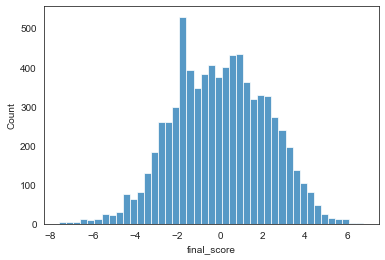

In [15]:
# taking a look at the distribution of final scores, we can see a regular 
# distribution

sns.histplot(scaled_voting_df['final_score'])

In [16]:
# dropping text_blob, vader_compound and bert_score as we have our labels

df = df.drop(columns=['text_blob', 'vader_compound', 'bert_scores'])

In [17]:
df['final_score'] = scaled_voting_df['final_score']
df.head()

,text,screen_name,user_description,favourite_count,retweet_count,created_at,replying_to,media,hashtags,urls,user_mentions,is_quote,is_retweet,final_score
0,“#Florida's death toll from #HurricaneIan tops...,AmPowerBlog,Sports Twitter is the best Twitter. 🏈🏇🎾🛹⚾🏌️😎🚴🏐...,0,0,2022-10-03 20:19:43+00:00,NaN,False,"[{'text': 'Florida', 'indices': [1, 9]}, {'tex...","[{'url': 'https://t.co/RqcyAHAxtk', 'expanded_...",[],False,False,-2.026085
1,Republicans. can’t. be. counted. on. to. do. ...,nivnos33,#RESISTER #Woke #Democrat #NeverGOP #VotingRig...,0,0,2022-10-03 20:19:22+00:00,NaN,False,"[{'text': 'VoteOutEveryRepublican', 'indices':...","[{'url': 'https://t.co/Me3qmrzTsX', 'expanded_...",[],True,False,-0.585280
2,Leadership you can Trust. 🦟 Make sure to like ...,TrishTheCommish,"#Commissioner, #Mom, #PublicServant, #Mosquito...",2,0,2022-10-03 20:19:09+00:00,NaN,True,"[{'text': 'leadbyexample', 'indices': [180, 19...",[],[],False,False,4.769675
3,"Hello Everyone,\n1/3) Many Floridians face flo...",Find_and_Bind1,"Amateur journalist, photographer, #bondage ent...",0,0,2022-10-03 20:18:56+00:00,NaN,False,"[{'text': 'HurricaneIan', 'indices': [112, 125...","[{'url': 'https://t.co/lgO1y1sFsK', 'expanded_...",[],False,False,-0.518498
4,"Lord, please be a refuge for those in need. Gi...",shellsfaith,My name is Shelly and this is where I will be ...,1,0,2022-10-03 20:18:45+00:00,NaN,False,"[{'text': 'HurricaneIan', 'indices': [195, 208...","[{'url': 'https://t.co/M4c6nH2x1U', 'expanded_...",[],True,False,0.676419


# Data Exploration

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7652 entries, 0 to 7651
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              7652 non-null   object 
 1   screen_name       7652 non-null   object 
 2   user_description  7364 non-null   object 
 3   favourite_count   7652 non-null   int64  
 4   retweet_count     7652 non-null   int64  
 5   created_at        7652 non-null   object 
 6   replying_to       1172 non-null   object 
 7   media             7652 non-null   bool   
 8   hashtags          7652 non-null   object 
 9   urls              7652 non-null   object 
 10  user_mentions     7652 non-null   object 
 11  is_quote          7652 non-null   bool   
 12  is_retweet        7652 non-null   bool   
 13  final_score       7652 non-null   float64
dtypes: bool(3), float64(1), int64(2), object(8)
memory usage: 680.1+ KB


In [19]:
df.shape

(7652, 14)

In [20]:
df['created_at'].min()

'2022-10-03 13:49:56+00:00'

Started scraping at 10/03/2022 at 1:50 pm EST.

In [21]:
df['created_at'].max()

'2022-10-11 23:59:26+00:00'

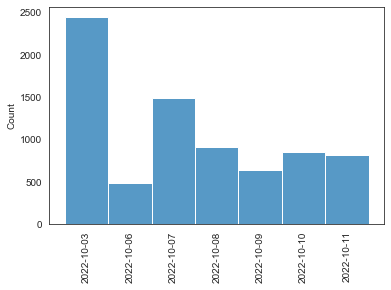

In [22]:
dates = [x.split(' ')[0] for x in df['created_at']]

sns.histplot(sorted(dates), bins = 7)
plt.xticks(rotation = 90);

Stopped scraping at 10/11/2022 at 11:59 pm EST. 

In future work, I want to really dig in and explore the correlations between sentiment and `favourite_count` or `retweet_count` and also explore all the features of this data. However, for the purposes of getting something deployed as fast as possible, with Hurricane Season on the way, I'm only going to be focusing on the text column. 

## Cleaning the Tweets

### Removing Emojis

I'll be using clean_text to remove emojis from the text. After trying this 
process both with and without emojis and having the F1 scores come back in the same
ranges, I've decided to remove the emojis, prioritizing making the text
vectors less multidementional 

In [23]:
# making a list of all tweets without emojis

no_emojis = [clean(x, no_emoji = True) for x in df['text']]
no_emojis[:10]

['"#florida\'s death toll from #hurricaneian tops 100 as the search for survivors continues #fortmyers #ftmyers #ian https://t.co/rqcyahaxtk',
 "republicans. can't. be. counted. on. to. do. the. right. thing.\never.\n#voteouteveryrepublican\n#votethemallout\n#hurricaneian https://t.co/me3qmrztsx",
 'leadership you can trust. make sure to like my commissioner trish becker anastasia mosquito control district page and share it with friends. vote by mail ballots went out today!\n#leadbyexample #vote #politics #hurricanian #hurricaneian #hurricane #staugustine #women #mosquito https://t.co/mhs9wz1bsc',
 'hello everyone,\n1/3) many floridians face flood damage from ian without flood insurance\nhttps://t.co/lgo1y1sfsk\n#hurricaneian #florida #flooddamage #insurance #fema #grants',
 'lord, please be a refuge for those in need. give them the comfort of your presence. bring them peace and give them strength to carry on in the midst of trouble and loss. in your holy name, amen.\n#hurricaneian #hu

In [24]:
# making no_emojis list into into a column, I'll be doing all my text processing 
# on this new column

df['no_emojis'] = no_emojis
df.head()

,text,screen_name,user_description,favourite_count,retweet_count,created_at,replying_to,media,hashtags,urls,user_mentions,is_quote,is_retweet,final_score,no_emojis
0,“#Florida's death toll from #HurricaneIan tops...,AmPowerBlog,Sports Twitter is the best Twitter. 🏈🏇🎾🛹⚾🏌️😎🚴🏐...,0,0,2022-10-03 20:19:43+00:00,NaN,False,"[{'text': 'Florida', 'indices': [1, 9]}, {'tex...","[{'url': 'https://t.co/RqcyAHAxtk', 'expanded_...",[],False,False,-2.026085,"""#florida's death toll from #hurricaneian tops..."
1,Republicans. can’t. be. counted. on. to. do. ...,nivnos33,#RESISTER #Woke #Democrat #NeverGOP #VotingRig...,0,0,2022-10-03 20:19:22+00:00,NaN,False,"[{'text': 'VoteOutEveryRepublican', 'indices':...","[{'url': 'https://t.co/Me3qmrzTsX', 'expanded_...",[],True,False,-0.585280,republicans. can't. be. counted. on. to. do. t...
2,Leadership you can Trust. 🦟 Make sure to like ...,TrishTheCommish,"#Commissioner, #Mom, #PublicServant, #Mosquito...",2,0,2022-10-03 20:19:09+00:00,NaN,True,"[{'text': 'leadbyexample', 'indices': [180, 19...",[],[],False,False,4.769675,leadership you can trust. make sure to like my...
3,"Hello Everyone,\n1/3) Many Floridians face flo...",Find_and_Bind1,"Amateur journalist, photographer, #bondage ent...",0,0,2022-10-03 20:18:56+00:00,NaN,False,"[{'text': 'HurricaneIan', 'indices': [112, 125...","[{'url': 'https://t.co/lgO1y1sFsK', 'expanded_...",[],False,False,-0.518498,"hello everyone,\n1/3) many floridians face flo..."
4,"Lord, please be a refuge for those in need. Gi...",shellsfaith,My name is Shelly and this is where I will be ...,1,0,2022-10-03 20:18:45+00:00,NaN,False,"[{'text': 'HurricaneIan', 'indices': [195, 208...","[{'url': 'https://t.co/M4c6nH2x1U', 'expanded_...",[],True,False,0.676419,"lord, please be a refuge for those in need. gi..."


### Removing Stopwords, Numbers, URLS, Punctuation and Lemmatizing 

I'll be using a combination of NLTK and spaCy along with some other smaller text libraries. 

In [25]:
# instantiating nlp and stopwords, adding some twitter specific and case 
# specific stopwords, as well as adding all digets and punctuation to stopwords

nlp = spacy.load('en_core_web_sm')

stopwords = nlp.Defaults.stop_words

stopwords_to_add = ["\n", "\n\n", "hurricaneian", "ian", "hurricane", 
                    "florida", "s", "amp", "th"]

for x in stopwords_to_add:
    stopwords.add(x)

for x in string.punctuation:
    stopwords.add(x)
    
for x in string.digits:
    stopwords.add(x)

print(stopwords)

{'anyone', 'here', 'thus', '1', 'no', '{', '`', '\n', '#', "'re", 'anyway', 'due', 'against', 'except', 'those', 'thereby', 'many', '~', 'whatever', 'someone', 'be', 'beforehand', 'out', 'indeed', 'go', 'namely', 'above', 'whose', 'too', 'somehow', "'ve", '=', 'most', 'sometimes', 'thereafter', 'there', 'his', 'upon', 're', 'meanwhile', '%', 'not', 'fifteen', 'hence', ')', 'almost', 'seems', 'n‘t', 'we', 'same', 'my', 'because', 'down', 'its', 'really', ']', 'th', 'through', 'nine', 'onto', 'across', 'been', 'another', '>', 'a', 'empty', 'others', 'now', 'used', 'elsewhere', '^', 'somewhere', 'more', 'ourselves', 'wherever', 'hereby', 'her', 'just', 'among', 'whereby', 'below', '3', 'else', '|', 'done', 'towards', 'least', '0', 'whereupon', 'together', 'every', 'again', 'please', 'afterwards', 'something', 'you', 'top', 'several', 'nowhere', 'herein', '_', 'n’t', 'until', 'anyhow', 'own', 'amongst', 'eleven', 'they', 'some', 'put', 'them', 'ever', 'serious', 'bottom', 'seeming', 'show'

The following code block is a bit hairy and I'd like to come back to it to make it
more organized and less nested for better performance. It does the following:

1) makes an empty list for doc tokens

2) for each row in the no_emojis column

3) make an empty list of all tokens in the tweet

4) "fix" the contractions in the tweet to keep meaning and remove punctuation ie "haven't" turns to "have not" and assign that string as "new_text"

5) make "new text" into a spaCy NLP doc

6) for each token in the spaCy NLP doc: if the token isn't in spaCy's punctuation AND if it's lemma_ (rootword) isn't a pronoun, and the token is neither a a spaCy number or a url: add token's lemma_ (rootword) to list 'tokens_in_text' after making it lower case and stripping it of surrounding spaces

7) for each token in 'tokens_in_text', filter out string.punctuation (filters more than just spaCy's punctuation) 

8) for each token in 'tokens_in_text', filter out string.digits (filters more than just spaCy's 'like_numb')

9) for teach token in 'tokens_in_text', filter out all stopwords (which should include both string.punctuation and string.digits, but after running this code block a few different ways, I find added filtration with all these steps.) 

10) make an object of a blank and remove all blank tokens from 'tokens_in_text'

11) adds final 'tokens_in_text' list to list of doc_tokens

12) list of doc_tokens becomes a new column in the df

In [26]:
contractions.add('Ft', 'Fort')

In [27]:
# remove all punctuation, numbers, stopwords 
# get lowercased lemma (rootword) from token
# make list of lemmas into new column in df

list_of_doc_tokens = []
for text in df['no_emojis']:
    tokens_in_text = []
    new_text = contractions.fix(text)
    doc = nlp(new_text)
    for token in doc:
        if not token.is_punct and token.lemma_ != '-PRON-' and not token.like_num\
        and not token.like_url:
            tokens_in_text.append(token.lemma_.lower().strip())

    tokens_in_text = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens_in_text]
    tokens_in_text = [token.translate(str.maketrans('', '', string.digits)) for token in tokens_in_text]
    tokens_in_text = [token for token in tokens_in_text if token not in set(stopwords)]
    
    blank = ''
    tokens_in_text = [token for token in tokens_in_text if token is not blank]
    list_of_doc_tokens.append(tokens_in_text)

df['tokens'] = list_of_doc_tokens
df.head()

KeyboardInterrupt: 

### Checking for Spammers

A bunch of tweets are bot tweets that post the same message with different links. Therefore now that the URLS are removed, I'll be checking once more for duplicates. 

In [ ]:
df = df.drop_duplicates(subset=['no_emojis', 'screen_name'])
df.shape

# this appears to have only gotten rid of 3 tweets. Instead I will explore
# how many of the rows are from the same users

In [ ]:
from collections import Counter
import itertools

users = [x for x in df['screen_name']]

counter_ = (Counter(users))

counter_ = dict(sorted(counter_.items(), key=lambda item: item[1], reverse = True))


top_20_spammers = dict(itertools.islice(counter_.items(), 20)) 
print(top_20_spammers)
top_20_spammers = [key for key in top_20_spammers.keys()]
top_20_spammers

In the future I'd like to sample the data by only grabbing one tweet for username
or at least a way to keep the first tweets by each of the spammers but for right now I'm just going to remove those rows from these users. 

BIAS: I am introducing bias into this data set here. Someone can be in distress and therefore tweeting about it frequently. Since I'll be making a lot of changes to data collection and training in the future anyway, I'm going to accept this bias as is for now and keep going. 

In [ ]:
df = df[~df['screen_name'].isin(top_20_spammers)]
df.shape

In [ ]:
df.head()

In [ ]:
df['final_score'] = scaled_voting_df['final_score']
sentiment_df = df.sort_values(by = 'final_score')
for x in sentiment_df.head().values:
    print(f'TEXT: {x[0]}\n\nSCORE: {x[13]}\n \
______________________________________________________________________________\n')

Observations: All the most negative tweets involve political figures except the last. That's very interesting especially since we can see that they don't agree. In the future I'll want to make tweets only like the last tweet included in the target. Right now, I'm going to use the data as is as a proof of concept until I get a chance to make better labels and filter out sales tweets. 

In [ ]:
for x in sentiment_df.tail().values:
    print(f'TEXT: {x[0]}\n\nSCORE: {x[13]}\n \
______________________________________________________________________________\n')

Observations: I'll want to go back and do more careful cleaning in the future so that the above three 'lifestyle content' posts and ones like it don't muddy the waters of the data, which appear to have gotten through my filters by posting new URLs and slightly different messages for each tweet, so they aren't recognized as duplicates. In the future, I'll need better filters to remove sales tweets. For the time being, I'm going to carry on since this won't effect the Negative Sentiment Class. 

I've decided to classify any final score over 0 to be in the positive sentiment
 class and any final scores that were below 0 into the negative class. The negative class will be the target class. 

In [ ]:
# making an empty list of labels, using a for loop to make my labels and making 
# that list into a column 
labels = []

for x in df['final_score']:
    if x > 0:
        labels.append(1)
    else:
        labels.append(0)
df['labels'] = labels
df.head()

In [ ]:
# looking at the distribution of classes, we have a pretty balenced data set

df['labels'].value_counts(normalize = True) 
# Classes for the target are balenced roughly, the difference is off by about 5% which is negligable 

# EDA on Negative and Positive Sentiment

In [ ]:
# seperating out the negative sentiment tweets and positive sentiment tweets 
# into two seperate dfs 

neg_df = df.loc[df['labels'] == 0]
pos_df = df.loc[df['labels'] == 1]

In [ ]:
# increasing the default number of max_length so I can make sure I can proceed

nlp.max_length = 1200000

### Top Words

In [ ]:
# making a string of all the tokens in the negative df and running that string 
# through the most_common function 

neg_doc_string = " ".join([item for sublist in neg_df['tokens'] for item in sublist])
common_neg = most_common(neg_doc_string, "Negative Sentiment Tweets")[1]
common_neg;

In [ ]:
# making a string of all the tokens in the postive df and running that string 
# through the most_common function 

pos_doc_string = " ".join([item for sublist in pos_df['tokens'] for item in sublist])
common_posi = most_common(pos_doc_string, "Positive Sentiment Tweets")[1]
common_posi;

### Bigrams

In [ ]:
neg_tokens = [token for sublist in neg_df['tokens'] for token in sublist]

bigrams(neg_tokens, "Negative Sentiment", 'negative_bigram')

In [ ]:
pos_tokens = [token for sublist in pos_df['tokens'] for token in sublist]

bigrams(pos_tokens, "Positive Sentiment", 'positive_bigram')

### Word Cloud

In [ ]:
neg_word_cloud = make_word_cloud(neg_doc_string, 'neg_word_cloud')
neg_word_cloud;

In [ ]:
posi_word_cloud = make_word_cloud(pos_doc_string, 'posi_word_cloud')
posi_word_cloud;

# Modeling

####  Method
I'll be using Random Forest, XGBoost, NaiveBayes and CatBooost to try and classify tweets into either positive or negative sentiment and then checking the labels against those predictions. For each algorithm, I'll be trying both a TFIDF vectorizer and a more simplistic CountVectorizer. I'll proceed with the algorithm and vector combination with the best F1 score relative to it's computation. 

### Train Test Split

I'll be splitting the data into 80% training data, 10% test data and 10% validation data.

In [ ]:
df.head()

In [ ]:
token_strings = []
for x in df['tokens']:
    string = " ".join(x)
    token_strings.append(string)
    
df['tokens'] = token_strings
df.head()

In [ ]:
# for the modeling purposes, I'll only be using the 'tokens' column and 'labels' column
X = df['tokens']
y = df['labels']

In [ ]:
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

In [ ]:
# To Do: make a TFIDF function and a Count Vectorizer function 

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_vectorizer.fit(X_train)
X_train_tfidf_vec = tfidf_vectorizer.transform(X_train)
X_test_tfidf_vec = tfidf_vectorizer.transform(X_test)
X_valid_tfidf_vec = tfidf_vectorizer.transform(X_valid)
X_train_tfidf_vec_df = pd.DataFrame(X_train_tfidf_vec.toarray())
X_valid_tfidf_vec_df = pd.DataFrame(X_valid_tfidf_vec.toarray())
X_train_tfidf_vec_df.shape

In [ ]:
count_vectorizer = CountVectorizer()

count_vectorizer.fit(X_train)
X_train_cv_vec = count_vectorizer.transform(X_train)
X_test_cv_vec = count_vectorizer.transform(X_test)
X_valid_cv_vec = count_vectorizer.transform(X_valid)
X_train_cv_vec_df = pd.DataFrame(X_train_cv_vec.toarray())
X_valid_cv_vec_df = pd.DataFrame(X_valid_cv_vec.toarray())
X_train_cv_vec_df.shape

In [ ]:
print(X_train_tfidf_vec.shape)
print(X_test_tfidf_vec.shape)
print(X_valid_tfidf_vec.shape)

In [ ]:
print(X_train_cv_vec.shape)
print(X_test_cv_vec.shape)
print(X_valid_cv_vec.shape)

### Random Forest Machine

In [ ]:
# making a GridsearchCV grid for a Random Forest Machine

rf_gscv_params = {
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf' : [1, 2, 3, 4, 5, 6],
    'max_features' : ['sqrt'],
    'criterion': ["gini", "entropy"],
    'class_weight': ['balanced']}

#### TFIDF

In [ ]:
# instantiating the random forest classifyer
rf_clf = RandomForestClassifier(random_state = 42)

#Applying classifyer and grid for the Gridsearch
rf_gs_tfidf = GridSearchCV(estimator = rf_clf, param_grid = rf_gscv_params, 
                           scoring = 'f1', cv = 5)

#Fitting model with the training data
rf_gs_tfidf.fit(X_train_tfidf_vec, y_train)

In [ ]:
# investigating the best params
rf_gs_tfidf.best_params_

In [ ]:
# getting my predictions from the best TFIDF random forest classyfier and evaluating
# those predictions 

y_preds = rf_gs_tfidf.predict(X_train_tfidf_vec)

evaluate(rf_gs_tfidf, X_train_tfidf_vec, y_train, y_preds)

We can see this Random Forest Classyfier was able to account for 98% of the variance in the test data. 

In [ ]:
# getting the predictions of this best random forest classyfier and trying those predictions 
# against the test labels for evaluation 

y_preds = rf_gs_tfidf.predict(X_test_tfidf_vec)

evaluate(rf_gs_tfidf, X_test_tfidf_vec, y_test, y_preds)

We can see a 10% drop in the ability of this random forest algorithm's ability to explain the variance and our F1 score dropped by about 10% on data the model had never seen before. This is a healthy drop and not concerning. 

#### Count Vectorizer

In [ ]:
#Applying classyfier and grid for the Gridsearch
rf_gs_cv = GridSearchCV(estimator = rf_clf, param_grid = rf_gscv_params, scoring = 'f1', cv = 5)

#Fitting model with the training data
rf_gs_cv.fit(X_train_cv_vec, y_train)

In [ ]:
# investigating best params

rf_gs_cv.best_params_

In [ ]:
# getting predictions to try against the training labels for evaluation

y_preds = rf_gs_cv.predict(X_train_cv_vec)

evaluate(rf_gs_cv, X_train_cv_vec, y_train, y_preds)

We can see this algorithm can explain 100% of the variance in the training data. 

In [ ]:
# Getting predictions for this random forest on test data for evaluation

y_preds = rf_gs_cv.predict(X_test_cv_vec)

evaluate(rf_gs_cv, X_test_cv_vec, y_test, y_preds)

This model also had a 10% drop in it's ability to explain the variance in the data, and our F1 score had another 10% healthy drop. 

### XG BOOST Machine

In [ ]:
# Importing Counter to do calculations for the weights for the model, 
# while this data is relatively balenced, this can't hurt
from collections import Counter
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

In [ ]:
#Setting of parameters for gridsearch to use
xgb_grid = {
    'learning_rate': [0.1, 0.3, 0.5, 0.7],
    'max_depth': [10, 11, 12, 13, 14],
    'min_child_weight': [1, 2],
    'subsample': [0.3, 0.5, 0.7],
    'n_estimators': [20, 25, 30]
}

#### TFIDF

In [ ]:
# instatiating the xgb classifyer
xg_clf = XGBClassifier()

#Applying classifyer and grid for the Gridsearch
xg_gs_tfidf = GridSearchCV(estimator = xg_clf, param_grid = xgb_grid, scoring = 'f1', cv = 5)

#Fitting model with the training data
xg_gs_tfidf.fit(X_train_tfidf_vec, y_train)

In [ ]:
# investigating the best params

xg_gs_tfidf.best_params_

In [ ]:
# getting predictions to try against the training labels

y_preds = xg_gs_tfidf.predict(X_train_tfidf_vec)
evaluate(xg_gs_tfidf, X_train_tfidf_vec, y_train, y_preds)

We can see the XGBoost algothim on TFIDF data was able to explain about 96% of the variance, 
but the F1 score is down from that AUC score by about 7%. 

In [ ]:
# getting predictions for XBGoost classyfier on TFIDF test data to try against 
# the labels for evaluation

y_preds = xg_gs_tfidf.predict(X_test_tfidf_vec)
evaluate(xg_gs_tfidf, X_test_tfidf_vec, y_test, y_preds)

The XGBoost model on the TFIDF training data could explain about 85% of the variance, down 10% from the training data. Likewise, this model's F1 score is down from 89% to about 78% in a healthy drop. 

#### Count Vectorizer

In [ ]:
#Applying classyfier and grid for the Gridsearch
xg_gs_cv = GridSearchCV(estimator = xg_clf, param_grid = xgb_grid, scoring = 'f1', cv = 5)

#Fitting model with the training data
xg_gs_cv.fit(X_train_cv_vec, y_train)

In [ ]:
# investigating the best params 
xg_gs_cv.best_params_

In [ ]:
# getting y predictions for classyfier to try against training lables for evaluation

y_preds = xg_gs_cv.predict(X_train_cv_vec)
evaluate(xg_gs_cv, X_train_cv_vec, y_train, y_preds)

The XGBoost model can expalin about the same amount of Variance in the training data when working on Count Vectorized data, likewise the F1 score is about the same, both only loosing about 1%. 

In [ ]:
# getting predictions for this classyfier on test data to try aginst labels for 
# Evaluation 

y_preds = xg_gs_cv.predict(X_test_cv_vec)
evaluate(xg_gs_cv, X_test_cv_vec, y_test, y_preds)

We can see the same healthy drop of about 10% in the AUC and F1 score for this model as well.

### Naive Bayes Machine

#### TFIDF

In [ ]:
# for the multinomail naive bayes algorithm I will not be trying GridSearch, 
# but instead be using the out-of-the-box Multinomial Naive Bayes algothim

nb_clf = MultinomialNB()

#Fitting model with the training data
nb_clf.fit(X_train_tfidf_vec.toarray(), y_train)

Since I didn't gridsearch this alorthim, training the algorithm is extreamly quick compared to the other algorithms. 

In [ ]:
# investigating the default params

nb_clf.get_params()

In [ ]:
# getting predictions for the Naive Bayes machine to try against the TFIDF training data
# for evaluation

# the Naive Bayes algorthim expects an array, not a sparse DF, hense the .toarray()

y_preds = nb_clf.predict(X_train_tfidf_vec.toarray())
evaluate(nb_clf, X_train_tfidf_vec.toarray(), y_train, y_preds)

Here, the Naive Bayes algorithm was able to account for about 96% of the variance with only a 5% drop from there in F1 score. 

In [ ]:
# getting the predictions the classyfier made to try against the test labels
# for evaluation 

y_preds = nb_clf.predict(X_test_tfidf_vec.toarray())
evaluate(nb_clf, X_test_tfidf_vec.toarray(), y_test, y_preds)

In the test data, the algorthim was able to explain 88% of the variance and the F1 score is about 80%, which is similar to other, much harder to train algorithms. Naive Bayes' positive advantages aren't in the F1 score or AUC score but in it's lightweight nature and quickness. 

#### Count Vectorizer

In [ ]:
#Fitting model with the training data
nb_clf.fit(X_train_cv_vec.toarray(), y_train)

In [ ]:
# Getting predictions of algorithm on training data to test against labels for evaluation 

y_preds = nb_clf.predict(X_train_cv_vec.toarray())
evaluate(nb_clf, X_train_cv_vec.toarray(), y_train, y_preds)

The Naive Bayes classifyer on CountVectorized training data was able to explain 96% of the variance, with the F1 score dropped about 6% from the AUC score at 90%, similar to the TFIDF metrics.  

In [ ]:
y_preds = nb_clf.predict(X_test_cv_vec.toarray())
evaluate(nb_clf, X_test_cv_vec.toarray(), y_test, y_preds)

Simliar to the TFIDF experiments, the Naive Bayes algorithm had about a 10% drop in it's ability to explain the variance in data it had never seen before. We see the same healthy drop in F1 score by about 11%. 

### Cat Boost

Catboost expects either a DataFrame or an Array, but not a sparse matrix.

In [ ]:
# instatiating the cat boost algorithm
cat_boost_clf = CatBoostClassifier(verbose = 0, 
                                  loss_function = 'Logloss')

In [ ]:
# making a catboost grid 
cat_boost_grid = {'iterations': [5000, 6000, 7000],
 'depth': [3, 4, 5],
 'learning_rate': [0.01, 0.02, 0.03]}

#### TFIDF

In [ ]:
#Applying classyfier and grid for the Gridsearch
cb_gs_tfidf = GridSearchCV(estimator = cat_boost_clf, param_grid = cat_boost_grid, 
                           scoring = 'f1', cv = 5)

#Fitting model with the training data
cb_gs_tfidf.fit(X_train_tfidf_vec.toarray(), y_train)

In [ ]:
# investigating the best params
cb_gs_tfidf.best_params_

In [ ]:
y_preds = get_cat_preds(cb_gs_tfidf, X_train_tfidf_vec.toarray())

In [ ]:
evaluate(cb_gs_tfidf, X_train_tfidf_vec.toarray(), y_train, y_preds)

In [ ]:
y_preds = get_cat_preds(cb_gs_tfidf, X_test_tfidf_vec.toarray())

In [ ]:
evaluate(cb_gs_tfidf, X_test_tfidf_vec.toarray(), y_test, y_preds)

#### Count Vectorizer 

In [ ]:
#Applying pipeline and grid for the Gridsearch
cb_gs_cv = GridSearchCV(estimator = cat_boost_clf, param_grid = cat_boost_grid, 
                        scoring = 'f1', cv = 5)

#Fitting model with the training data
cb_gs_cv.fit(X_train_cv_vec.toarray(), y_train)

In [ ]:
cb_gs_cv.best_params_

In [ ]:
y_preds = get_cat_preds(cb_gs_cv, X_train_cv_vec.toarray())

In [ ]:
evaluate(cb_gs_cv, X_train_cv_vec.toarray(), y_train, y_preds)

In [ ]:
y_preds = get_cat_preds(cb_gs_cv, X_test_cv_vec.toarray())

In [ ]:
evaluate(cb_gs_cv, X_test_cv_vec.toarray(), y_test, y_preds)

# Validation

In [ ]:
reports

In [ ]:
precision_scores = []

for x in reports:
    for item in x.items():
        if 'macro avg' in item:
            precision_scores.append(item[1]['precision'])
            
            
names = ['Random Forest TFIDF train', 'Random Forest TFIDF test',
         'Random Forest CV train', 'Random Forest CV test',
        'XG Boost TFIDF train', 'XG Boost TFIDF test',
        'XG Boost CV train', 'XG Boost CV test',
        'Naive Bayes TFIDF train', 'Naive Bayes TFIDF test',
        'Naive Bayes CV train', 'Naive Bayes CV test',
        'CatBoost TFIDF train', 'Catboost TFIDF test',
        'Catboost CV train', 'Catboost CV test']

precision_scores = pd.DataFrame(list(zip(names, precision_scores)))
precision_scores.sort_values(by = [1])

##### I'll be choosing the Catboost algorithm and using the CV data since that did the best (although marginally.) 

In [ ]:
best_params = cb_gs_cv.best_params_
best_params

In [ ]:
best_cat = CatBoostClassifier('depth' = 5, 'iterations' = 5000, 'learning_rate' = 0.03, 
                    verbose = 0, loss_function = 'Logloss')
best_cat.fit(X_train_cv_vec, y_train)

In [ ]:
y_preds = best_cat.predict(X_valid_cv_vec)
evaluate(best_cat, X_valid_cv_vec, y_valid, y_preds)

# Saving the model

In [ ]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(best_cat, open(filename, 'wb'))

## Explainer with CatBoost

In [ ]:
feature_importances = best_cat.feature_importances_
feature_importances

In [ ]:
tokens_by_name = tfidf_vectorizer.get_feature_names_out(X_train_tfidf_vec)
tokens_by_name

In [ ]:
feature_importances = list(zip(feature_importances, tokens_by_name))
feature_importances_df = pd.DataFrame(feature_importances)
feature_importances_df.head()

In [ ]:
only_import = feature_importances_df.loc[feature_importances_df[0] != 0.0]
only_import

In [ ]:
only_import[2] = only_import[0].astype(str) + ' ' + only_import[1]
most_important_terms = sorted(only_import[2], reverse = True)
top_50 = most_important_terms[:50]
top_50

In [ ]:
top_50_terms = [x.split(' ')[1] for x in top_50]
top_50_terms_string = " ".join(top_50_terms)
top_50_terms_string

### Explainer with Lime

In [ ]:
X_sample_strings = [X[x] for x in range(10)]
X_sample_strings

In [ ]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline_vectorizer, best_cat)

In [ ]:
import lime
from lime import lime_text

sns.set_style('white')

labels = ['Negative Sentiment', 'Positive Sentiment']
explainer = lime.lime_text.LimeTextExplainer(class_names = labels)

for x in X_sample_strings:
    print(x)
    exp = explainer.explain_instance(x, pipeline.predict_proba, num_features=5, top_labels=1)
    exp.show_in_notebook(text=True)

In [ ]:
most_common_posi_words = most_common(pos_doc_string, 'Positive Sentiment')[0]
most_common_posi_words

In [ ]:
for x in most_common_posi_words:
    exp = explainer.explain_instance(str(x), pipeline.predict_proba, num_features=50)
    exp.show_in_notebook(text=False)

In [ ]:
most_common_neg_words = most_common(neg_doc_string, 'Negative Sentiment')[0]
most_common_neg_words

In [ ]:
for x in most_common_neg_words:
    exp = explainer.explain_instance(str(x), pipeline.predict_proba, num_features=50)
    exp.show_in_notebook(text=False)

Observations: 

In [ ]:
exp = explainer.explain_instance(top_50_terms_string, pipeline.predict_proba, num_features=50)
exp.show_in_notebook(text=True)

Conclusion: As we can see from our 